# Second exercise (Chapter 6 & 8)

In this exercise we consider Chapters 6 & 8 of the book "Deep Learning". The exercise focuses on implementing a small feedforward neural network and training it on the MNIST dataset.

We provide code for structure and utility, you have to **fill in the TODO-gaps**.
It might initially look like a lot of unnecessary code, but it keeps the network extensible. In the following exercises you can reuse what you've done here. Most common neural network libraries (*pytorch*, *tensorflow/keras*, …) are similarly structured, hence they will be easy to use once you've finished this notebook. As we will be using *pytorch* towards the end of the lecture, our API resembles the API of the pytorch framework.


We will implement two different cost functions and play a bit with the value of the different hyperparameters to see how performances change as a function of those. In particular, we will focus on

* Sigmoid Neurons
* Stochastic Gradient Descent
* Quadratic Cost Function
* Cross Entropy Cost Function
* Learning Rate
* Generalization

Note that we'll implement all of these operations to operate on mini-batches of data.

In [1]:
# Some imports used in the code below

from typing import Iterable, List, Optional, Tuple  # type annotations
import pickle  # data loading
import gzip  # data loading

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
import scipy.optimize  # gradient check

The cell below contains the two main classes to structure your network. 

**Parameter** is used to represent trainable variables in the network, e.g., a layer's weights $w$. The weights themself are a *numpy array* as the parameter's `data` attribute. The associated parameter gradient (e.g. $\frac{\partial L}{\partial w}$) can be stored in the `grad` attribute.



**Module** is the base class for all parts of the network (activations, layers, …) and even the network itself. They all have to implement the `forward` and `backward` methods. For backpropagation activation will flow *forward* and gradient will flow *backward* through the *network graph and it's modules*. 

Additional module provides utility to check the correctness of implementation by approximating *backward* with [finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference#Relation_with_derivatives)  of *forward*.

*Note:* All modules operate on batches of samples. E.g. the input shape of `Linear.forward` is `(batch_size, feature_shape, 1)` (we will use the last dimension in future exercises).

In [2]:
class Parameter:
    """A trainable parameter.

    This class not only stores the value of the parameter (self.data) but also tensors/
    properties associated with it, such as the gradient (self.grad) of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, grad: Optional[np.ndarray] = None, name=None):
        self.data = data  # type: np.ndarray
        self.grad = grad  # type: Optional[np.ndarray]
        self.name = name  # type: Optional[str]
        self.state_dict = dict()  # dict to store additional, optional information
        
        
class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))

# Nonlinearities

## Sigmoid 

Implement your first network module: The sigmoid activation function.

Verify your sigmoid function by plotting.

In [3]:
class Sigmoid(Module):
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1/(1+np.exp(-z))

    def forward(self, z: np.ndarray) -> np.ndarray:
        assert len(z.shape) == 3, ("z.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(z.shape))
        # here it's useful to store the activation 
        # instead of the input
        self.input_cache = z
        h = self._sigmoid(z)
        
        return h

    def backward(self, grad: np.ndarray) -> np.ndarray:
        h = self.input_cache
        
        return grad * self._sigmoid(h) * (1 - self._sigmoid(h))

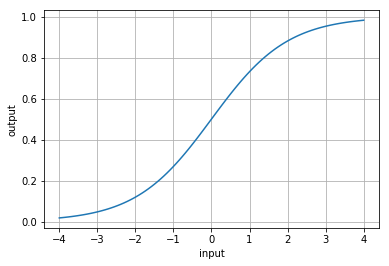

In [4]:
x = np.linspace(-4, +4, 100)
sigmoid = Sigmoid()

y = np.ravel(sigmoid(x.reshape(-1, 1, 1)))
# equal to call of sigmoid.forward(x)
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

## Relu

Implement Relu and plot for verification

In [5]:
class Relu(Module):
    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        return np.maximum(z,0)

    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
        return grad * np.maximum(np.sign(z),0)

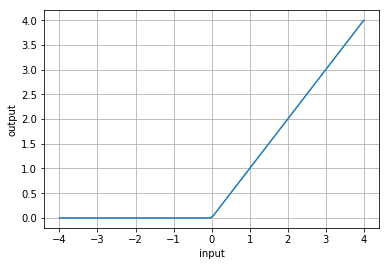

In [6]:
# Plot Relu
x = np.linspace(-4, +4, 100)
relu = Relu()

y = np.ravel(relu(x.reshape(-1, 1, 1)))
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

## Softmax

Implement the numerical stable softmax. We will not need the backward pass. 

In [7]:
class Softmax(Module):
    def _softmax(self, z):
        reduction_axes = tuple(range(1, len(z.shape))) 
        
        h = np.zeros(z.shape)
        for i in range(len(z)):
            feat = z[i]
            maxFeat = np.max(feat)
            h[i] = np.exp(feat-maxFeat) / np.sum(np.exp(feat-maxFeat))

        return h
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        h = self._softmax(z)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)

In [8]:
# Check your softmax
softmax = Softmax()
x = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]).reshape(1, -1, 1)

# Testcase from https://en.wikipedia.org/wiki/Softmax_function#Example
np.testing.assert_allclose(
    np.ravel(softmax(x)), 
    [0.02364054, 0.06426166, 0.1746813, 0.474833, 0.02364054, 0.06426166, 0.1746813],
    rtol=1e-5, err_msg="Softmax is not correct implemented")


# Linear Layer

Implement a linear (in other frameworks also called dense or fully connected) network layer. 
Here you also have to use the Parameter class.

In [9]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        w_data = 0.01 * np.random.randn(out_features, in_features)
        self.W = Parameter(w_data, "W")
        
        b_data = 0.01 * np.ones((out_features, 1))
        self.b = Parameter(b_data, "b")
        
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
                
        out = np.zeros((x.shape[0],self.out_features,1))
        
        for i in range(len(x)):
            out[i] = self.W.data@x[i]+self.b.data

        return out

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        # remember that input has a batch dimension when transposing, i.e.,
        # we need to use np.transpose instead of x.T
        x_transpose = np.transpose(x, [0, 2, 1])
                        
        self.W.grad = np.zeros(self.W.data.shape)
        self.b.grad = np.zeros(self.b.data.shape)
        
        for i in range(len(x)):
            self.W.grad += grad[i]*x_transpose[i][0]
            self.b.grad += grad[i]   
        
        out = np.zeros(x.shape)
        
        for i in range(len(x)):
            out[i] = (self.W.data.T@grad[i])
                        
        return out
        
        
    def parameters(self) -> List[Parameter]:
        return [self.W, self.b]

# Cost Functions



In [10]:
# Define the Cross-Entropy cost functions
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        r = -np.sum(np.log(a[y == 1])) / len(a)
        return -np.sum(np.log(a[y == 1])) / len(a)

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        a, y = self.input_cache
        
        if np.array_equal(a.shape, y.shape):
            z = (a-y) / len(a)
        else:
            z = (a.reshape(y.shape)-y) / len(a)
        z = z.reshape((a.shape[0], a.shape[1], 1)) 
        
        assert len(z.shape) == 3, ("CrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                   " but is {}.".format(z.shape))
        return z


class MSELoss(Module):
    """Compute the mean squared error loss."""

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.input_cache = a, y
        return np.sum(0.5 * np.linalg.norm(a - y, axis=-1)**2) / len(a)

    def backward(self, _=None):
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg
        a, y = self.input_cache
        
        z = (a-y) / len(a)
        z = z.reshape((a.shape[0], a.shape[1], 1))
        
        assert len(z.shape) == 3, ("MSELossCrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                   " but is {}.".format(z.shape))
        return z

# Sequential Network

In [11]:
class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        for elem in self.modules:
            x = elem(x)
            
        return x

    def backward(self, grad: np.ndarray) -> np.ndarray:
        for elem in reversed(self.modules):
            grad = elem.backward(grad)
        
        return grad

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]

# One hot encoding
To handle categorical data, we need to implement the one_hot_encoding utility function.

In [12]:
def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 1]]
    """

    encoded = np.zeros((len(y),num_classes))
    for i in range(len(y)):
        encoded[i][y[i]] = 1
    
    return encoded

y = np.array([1, 2, 0])
np.testing.assert_equal(one_hot_encoding(y, 3), [[0, 1, 0], [0, 0, 1], [1, 0, 0]]) 

# Gradient Check

Gradient checking is a useful utility to check, whether forward and backward pass are matching. 
Backward passes are approximated by finite differences of the forward pass.
We have implemented the gradient checking in the Module class for you. As all classes we defined up to here inherit from Module, we can run `check_gradients`.

In [13]:
input_vector = np.random.uniform(-1., 1., size=(2, 10, 1))
input_args = (input_vector,)

# layers + activations
Relu().check_gradients(input_args)
Sigmoid().check_gradients(input_args)
Linear(10, 30).check_gradients(input_args)

# MLP
seq = Sequential(Linear(10,30), Sigmoid(), Linear(30,10), Sigmoid())
seq.check_gradients(input_args)

# losses
input_args_losses = (one_hot_encoding(np.array([1, 2]), 3),  # a
                     one_hot_encoding(np.array([1, 1]), 3))  # y (ground truth)

MSELoss().check_gradients(input_args_losses)
CrossEntropyLoss().check_gradients(input_args_losses)

# Optimizers

Below you see the base class for all optimizers. An Optimizer needs to implement the `step()` function, which updates the parameters passed to the constructor.

In [14]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)

## SGD

Implement stochastic gradient descent (Chapter 5, Chapter 8). 
The momentum parameter improves training speed (Chapter 8.3).

In [15]:
class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                temp = self.momentum*p.state_dict["momentum"] - self.lr*p.grad
                p.data = p.data + temp
                p.state_dict["momentum"] = temp  
            else:
                p.data = p.data-self.lr*p.grad

## Data Loading

In [16]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

## Training

Implement the actual training loop.

In [17]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, batch_size, loss_fn):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        # note that when using cross entropy loss, the softmax is included in the
        # loss and we'd need to apply it manually here to obtain the output as probabilities.
        # However, softmax only rescales the outputs and doesn't change the argmax,
        # so we'll skip this here, as we're only interested in the class prediction.
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(y_val, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)
        
        # train for one epoch
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            model.backward(loss_fn.backward())
            optimizer.step()
            training_predictions.append(outputs)
            train_costs[epoch] += loss
       
        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, batch_size, loss_fn)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

** Your feedback on exercise 2.2: ** 


# Experiments

Apply it on a sequential model (linear, sigmoid, linear, softmax (included in cross entropy!). Use the cross entropy loss and sgd with momentum. Use the hyperparameters defined below.

What is the best accuracy you can achieve?

In [18]:
num_epochs = 10
batch_size = 50
learning_rate = 0.1
momentum = 0.9
linear_units = 30

# Train the model here!
seq = Sequential(Linear(784,linear_units), Sigmoid(), Linear(linear_units,10))
sgd = SGD(seq.parameters(), learning_rate, momentum)
cel = CrossEntropyLoss()

train(seq, cel, sgd, x_train, y_train, x_val, y_val, num_epochs, batch_size)

Epoch 1 / 10:
  Training Accuracy: 0.8497
  Training Cost: 483.8895
  Eval Accuracy: 0.9359
Epoch 2 / 10:
  Training Accuracy: 0.9426
  Training Cost: 198.7770
  Eval Accuracy: 0.9538
Epoch 3 / 10:
  Training Accuracy: 0.9533
  Training Cost: 156.5814
  Eval Accuracy: 0.9579
Epoch 4 / 10:
  Training Accuracy: 0.9603
  Training Cost: 133.0025
  Eval Accuracy: 0.9587
Epoch 5 / 10:
  Training Accuracy: 0.9646
  Training Cost: 117.0638
  Eval Accuracy: 0.9646
Epoch 6 / 10:
  Training Accuracy: 0.9688
  Training Cost: 105.0019
  Eval Accuracy: 0.9648
Epoch 7 / 10:
  Training Accuracy: 0.9711
  Training Cost: 97.3403
  Eval Accuracy: 0.9652
Epoch 8 / 10:
  Training Accuracy: 0.9740
  Training Cost: 88.1999
  Eval Accuracy: 0.9644
Epoch 9 / 10:
  Training Accuracy: 0.9759
  Training Cost: 82.1532
  Eval Accuracy: 0.9676
Epoch 10 / 10:
  Training Accuracy: 0.9766
  Training Cost: 77.3859
  Eval Accuracy: 0.9669


(array([483.88947877, 198.77696504, 156.58139101, 133.00249282,
        117.06379822, 105.00190892,  97.34031532,  88.19993908,
         82.15319115,  77.38585731]),
 array([0.84972, 0.94256, 0.95326, 0.96028, 0.9646 , 0.96884, 0.97106,
        0.974  , 0.97592, 0.97656]),
 array([42.96234931, 32.47103781, 30.12737541, 27.77076278, 25.14429048,
        24.76893124, 24.36572516, 24.89820895, 23.0241904 , 24.10425481]),
 array([0.9359, 0.9538, 0.9579, 0.9587, 0.9646, 0.9648, 0.9652, 0.9644,
        0.9676, 0.9669]))

Now run again with the increased learning rate. Which accuracy can you achieve now? How did the accuracies change while training, compared to the lower learning rate?

**Note:** Make sure, to reinitialize your model's parameters. Don't continue on the already trained parameters.

In [19]:
higher_learning_rate = 3

seq = Sequential(Linear(784,linear_units), Sigmoid(), Linear(linear_units,10))
sgd = SGD(seq.parameters(), higher_learning_rate, momentum)
train(seq, cel, sgd, x_train, y_train, x_val, y_val, num_epochs, batch_size)

Epoch 1 / 10:
  Training Accuracy: 0.1012
  Training Cost: 2454.9261
  Eval Accuracy: 0.0915
Epoch 2 / 10:
  Training Accuracy: 0.0999
  Training Cost: 2451.5076
  Eval Accuracy: 0.1090
Epoch 3 / 10:
  Training Accuracy: 0.0994
  Training Cost: 2455.1063
  Eval Accuracy: 0.1064
Epoch 4 / 10:
  Training Accuracy: 0.1000
  Training Cost: 2445.9349
  Eval Accuracy: 0.1030
Epoch 5 / 10:
  Training Accuracy: 0.1012
  Training Cost: 2454.6799
  Eval Accuracy: 0.1064
Epoch 6 / 10:
  Training Accuracy: 0.0999
  Training Cost: 2464.4894
  Eval Accuracy: 0.0990
Epoch 7 / 10:
  Training Accuracy: 0.1006
  Training Cost: 2448.8451
  Eval Accuracy: 0.1064
Epoch 8 / 10:
  Training Accuracy: 0.0989
  Training Cost: 2457.9710
  Eval Accuracy: 0.1064
Epoch 9 / 10:
  Training Accuracy: 0.1002
  Training Cost: 2440.3737
  Eval Accuracy: 0.1064
Epoch 10 / 10:
  Training Accuracy: 0.1008
  Training Cost: 2458.5813
  Eval Accuracy: 0.0983


(array([2454.92612642, 2451.50760442, 2455.10631739, 2445.93488018,
        2454.67992374, 2464.48941004, 2448.84507036, 2457.97104799,
        2440.3737459 , 2458.58133693]),
 array([0.10122, 0.09986, 0.09944, 0.10002, 0.10116, 0.09992, 0.1006 ,
        0.0989 , 0.10022, 0.10084]),
 array([507.3670553 , 482.78496994, 480.52551697, 513.25995777,
        499.34356228, 499.16887392, 493.22623113, 502.58325165,
        485.59216861, 496.44031173]),
 array([0.0915, 0.109 , 0.1064, 0.103 , 0.1064, 0.099 , 0.1064, 0.1064,
        0.1064, 0.0983]))

Train only a subset of 1000 training samples, but for 300 epochs. 
Plot the costs & accuracies for both training and validation.

How do the accuracies change compared to the previous runs?
How is this plot related to the term 'overfitting'?

In [20]:
num_train_samples = 1000
num_epochs = 300

seq = Sequential(Linear(784,linear_units), Sigmoid(), Linear(linear_units,10))
sgd = SGD(seq.parameters(), learning_rate, momentum)
cel = CrossEntropyLoss()
train_costs, train_accuracies, eval_costs, eval_accuracies = train(
    seq, 
    cel, 
    sgd, 
    x_train[:num_train_samples], 
    y_train[:num_train_samples], 
    x_val, 
    y_val, 
    num_epochs, 
    batch_size
)

Epoch 1 / 300:
  Training Accuracy: 0.0990
  Training Cost: 46.2669
  Eval Accuracy: 0.1957
Epoch 2 / 300:
  Training Accuracy: 0.1490
  Training Cost: 45.4565
  Eval Accuracy: 0.1759
Epoch 3 / 300:
  Training Accuracy: 0.3350
  Training Cost: 39.0744
  Eval Accuracy: 0.5679
Epoch 4 / 300:
  Training Accuracy: 0.6340
  Training Cost: 25.4174
  Eval Accuracy: 0.6633
Epoch 5 / 300:
  Training Accuracy: 0.7680
  Training Cost: 17.1814
  Eval Accuracy: 0.7834
Epoch 6 / 300:
  Training Accuracy: 0.8460
  Training Cost: 12.3943
  Eval Accuracy: 0.8339
Epoch 7 / 300:
  Training Accuracy: 0.8750
  Training Cost: 9.7485
  Eval Accuracy: 0.8405
Epoch 8 / 300:
  Training Accuracy: 0.8860
  Training Cost: 8.5262
  Eval Accuracy: 0.8457
Epoch 9 / 300:
  Training Accuracy: 0.9070
  Training Cost: 7.0644
  Eval Accuracy: 0.8615
Epoch 10 / 300:
  Training Accuracy: 0.9240
  Training Cost: 6.1861
  Eval Accuracy: 0.8672
Epoch 11 / 300:
  Training Accuracy: 0.9350
  Training Cost: 5.4195
  Eval Accuracy

  Training Accuracy: 1.0000
  Training Cost: 0.1573
  Eval Accuracy: 0.8801
Epoch 91 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1550
  Eval Accuracy: 0.8799
Epoch 92 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1534
  Eval Accuracy: 0.8805
Epoch 93 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1507
  Eval Accuracy: 0.8803
Epoch 94 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1481
  Eval Accuracy: 0.8802
Epoch 95 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1459
  Eval Accuracy: 0.8805
Epoch 96 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1441
  Eval Accuracy: 0.8810
Epoch 97 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1419
  Eval Accuracy: 0.8803
Epoch 98 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1399
  Eval Accuracy: 0.8801
Epoch 99 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1379
  Eval Accuracy: 0.8803
Epoch 100 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1360
  Eval Accuracy: 0.8803
Epo

  Eval Accuracy: 0.8807
Epoch 179 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0632
  Eval Accuracy: 0.8809
Epoch 180 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0628
  Eval Accuracy: 0.8807
Epoch 181 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0623
  Eval Accuracy: 0.8806
Epoch 182 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0619
  Eval Accuracy: 0.8803
Epoch 183 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0615
  Eval Accuracy: 0.8807
Epoch 184 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0610
  Eval Accuracy: 0.8808
Epoch 185 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0607
  Eval Accuracy: 0.8807
Epoch 186 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0604
  Eval Accuracy: 0.8809
Epoch 187 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0599
  Eval Accuracy: 0.8807
Epoch 188 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0595
  Eval Accuracy: 0.8804
Epoch 189 / 300:
  Training Accuracy: 1.0000
 

  Eval Accuracy: 0.8805
Epoch 268 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0384
  Eval Accuracy: 0.8808
Epoch 269 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0382
  Eval Accuracy: 0.8806
Epoch 270 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0380
  Eval Accuracy: 0.8810
Epoch 271 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0379
  Eval Accuracy: 0.8808
Epoch 272 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0377
  Eval Accuracy: 0.8806
Epoch 273 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0375
  Eval Accuracy: 0.8811
Epoch 274 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0374
  Eval Accuracy: 0.8807
Epoch 275 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0372
  Eval Accuracy: 0.8809
Epoch 276 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0371
  Eval Accuracy: 0.8810
Epoch 277 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0369
  Eval Accuracy: 0.8809
Epoch 278 / 300:
  Training Accuracy: 1.0000
 

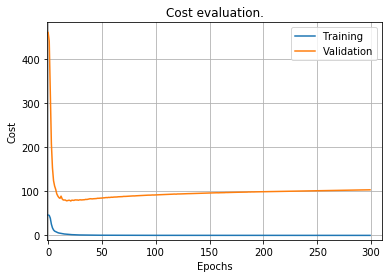

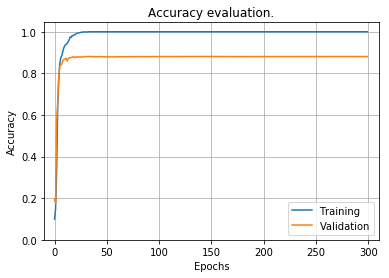

In [22]:
plt.figure(1)
plt.title('Cost evaluation.')
plt.plot(train_costs, label='Training')
plt.plot(eval_costs, label='Validation')
plt.legend(loc='best')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.ylim(bottom=-10)
plt.xlim(left=-1)
plt.xlim(right=310)
plt.grid(True)

plt.figure(2)
# Plot accuracies here
# START TODO ################
plt.title('Accuracy evaluation.')
plt.plot(train_accuracies, label='Training')
plt.plot(eval_accuracies, label='Validation')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(bottom=0)
plt.xlim(left=-10)
plt.xlim(right=310)
plt.grid(True)
# END TODO ##################

plt.show()

## How is this plot related to the term 'overfitting'?
* One can see, that arround epoch 30 the model can classify the whole training set correctly as it's training accuracy reaches 1.
* Going further, the training loss gets slightly better but we can observe a rising validation cost, which is a clear indicator of overfitting.

** Your feedback on exercise 2.3: ** 
